## Different demos with Vertex AI

### Llmaindex with Google Gen AI

Examples on how to use the google-genai Python SDK with LlamaIndex to interact with Google GenAI models.

#### Install necessary packages

In [ ]:
!pip install -U llama-index-llms-google-genai llama-index google-genai dotenv

#### Set Global Variables

In [1]:
from dotenv import load_dotenv

import os
import time

load_dotenv()

MODEL="gemini-2.5-flash" # @param ["gemini-3-pro-preview", "gemini-3-flash-preview", "gemini-2.5-flash", "gemini-2.5-flash-lite", "gemini-2.5-pro"]
PROJECT_ID=os.getenv("GCP_PROJECT_ID")
LOCATION=os.getenv("GCP_LOCATION")
API_KEY = os.getenv("GOOGLE_API_KEY")

#### Basic Usage

In [2]:

from llama_index.llms.google_genai import GoogleGenAI

llm = GoogleGenAI(
    model=MODEL,
    vertexai_config={"project": PROJECT_ID, "location": LOCATION},
    context_window=200000,
    max_tokens=512,
)

resp = await llm.acomplete("Who is Paul Graham? Provide a short answer in 2 sentences.")
print(resp.text)

Paul Graham is a prominent computer scientist, essayist, and venture capitalist, best known as the co-founder of the influential startup accelerator Y Combinator. He is also recognized for his insightful essays on technology, startups, and programming, which have significantly shaped the modern tech and venture capital landscape.


#### Basic Usage (streaming)

In [3]:

llm = GoogleGenAI(
    model=MODEL,
    vertexai_config={"project": PROJECT_ID, "location": LOCATION}
)

resp = await llm.astream_complete("Who is Paul Graham?")
async for r in resp:
    print(r.delta, end="")

Paul Graham is a highly influential American computer scientist, programmer, essayist, venture capitalist, and entrepreneur. He is best known as the **co-founder of Y Combinator**, one of the world's most successful and prestigious startup accelerators.

Here's a breakdown of his key contributions and roles:

1.  **Viaweb (1995-1998):** Before Y Combinator, Graham co-founded Viaweb with Robert Morris. It was one of the first software-as-a-service (SaaS) companies, allowing users to build online stores. Viaweb was acquired by Yahoo! in 1998 for 49 million dollars, becoming Yahoo! Store. This experience gave him firsthand insight into the challenges and opportunities of early-stage startups.

2.  **Lisp Programmer and Advocate:** Graham is a strong advocate for the Lisp programming language. He wrote several influential books on Lisp, including "On Lisp" (1993) and "ANSI Common Lisp" (1995), which are considered classics in the field. His essays often highlight the power and elegance of 

#### Cached Content Support

Google GenAI supports cached content for improved performance and cost efficiency when reusing large contexts across multiple requests. This is particularly useful for RAG applications, document analysis, and multi-turn conversations with consistent context.

1. Create cached content - upload a local file

In [4]:
from google import genai
from google.genai.types import CreateCachedContentConfig, Content, Part

client = genai.Client(api_key=API_KEY)

pdf_file = client.files.upload(file="./learn-genai.pdf")

while pdf_file.state.name == "PROCESSING":
    print("Waiting for PDF to be processed.")
    time.sleep(2)
    pdf_file = client.files.get(name=pdf_file.name)

# Create cache with uploaded file
cache = client.caches.create(
    model=MODEL,
    config=CreateCachedContentConfig(
        display_name="Document Analysis Cache",
        system_instruction=(
            "You are an expert document analyzer. Answer questions "
            "based on the provided document with accuracy."
        ),
        contents=[pdf_file],  # Direct file reference
        ttl="3600s",  # Cache for 1 hour
    ),
)

print(f"Cache created: {cache.name}")
print(f"Cached tokens: {cache.usage_metadata.total_token_count}")

Cache created: cachedContents/s47jse3fl0b3wf9mlp33fjh91vzvrjaakwyxy7x8
Cached tokens: 2341


2. Using Cached Content with LlamaIndex

In [5]:
from llama_index.core.llms import ChatMessage

llm = GoogleGenAI(
    model=MODEL,
    api_key=API_KEY,
    cached_content=cache.name
)

message = ChatMessage(
    role="user", content="Summarize the key points from the document in max 5 sentences."
)
response = await llm.achat([message])
print(response)

assistant: Generative AI (GenAI) focuses on creating new, original content like text, images, and code, unlike discriminative AI which classifies existing data. Large Language Models (LLMs) are a core GenAI type, built on the Transformer architecture that uses numerical "embeddings" to represent words and "attention mechanisms" to understand their context and relationships. LLMs process text in "tokens" and have a "context window" that limits the amount of information they can consider, both of which have significant security implications. Advanced applications include Agentic AI, which enables LLMs to perceive, plan, and take autonomous actions. This autonomy introduces unique security challenges such as unintended actions, manipulation, and accountability concerns.


3. Cache Management

In [6]:
# List all caches
caches = client.caches.list()
for cache_item in caches:
    print(f"Cache: {cache_item.display_name} ({cache_item.name})")
    print(f"\tTokens: {cache_item.usage_metadata.total_token_count}")
    print(f"\tCreated: {cache_item.create_time}")
    print(f"\tExpires: {cache_item.expire_time}")
    answer = input(f"Do you want to delete cache '{cache_item.display_name}'? (y/n): ")
    if answer.lower() == "y":
        client.caches.delete(name=cache_item.name)
        print(f"\t--> Cache '{cache_item.name}' deleted.")

Cache: Document Analysis Cache (cachedContents/s47jse3fl0b3wf9mlp33fjh91vzvrjaakwyxy7x8)
	Tokens: 2341
	Created: 2026-02-22 19:57:12.492301+00:00
	Expires: 2026-02-22 20:57:11.681379+00:00
Cache: Document Analysis Cache (cachedContents/gd5l8lzuqchmq3webcnn1zutmoy1s0il9q87o63p)
	Tokens: 2341
	Created: 2026-02-22 19:13:46.803991+00:00
	Expires: 2026-02-22 20:13:45.636985+00:00


#### Multi-Modal Support

Using ChatMessage objects, you can pass in images, PDF and text to the LLM.

In [7]:
from llama_index.llms.google_genai import GoogleGenAI
from llama_index.core.llms import ChatMessage, TextBlock, DocumentBlock

llm = GoogleGenAI(
    model=MODEL,
    vertexai_config={"project": PROJECT_ID, "location": LOCATION}
)

messages = [
    ChatMessage(
        role="user",
        blocks=[
            DocumentBlock(
                path="./learn-genai.pdf",
                document_mimetype="application/pdf",
            ),
            TextBlock(text="What is the title of the PDF document?"),
        ],
    )
]

resp = await llm.achat(messages)
print(resp)

assistant: The title of the PDF document is "Learning Generative AI".


#### Structured Prediction

LlamaIndex provides an intuitive interface for converting any LLM into a structured LLM through _structured_predict_ - simply define the target Pydantic class (can be nested), and given a prompt, we extract out the desired object.

In [8]:
from llama_index.llms.google_genai import GoogleGenAI
from llama_index.core.prompts import PromptTemplate
from llama_index.core.bridge.pydantic import BaseModel
from typing import List

class MenuItem(BaseModel):
    """A menu item in a restaurant."""

    course_name: str
    is_vegetarian: bool

class Restaurant(BaseModel):
    """A restaurant with name, city, and cuisine."""

    name: str
    city: str
    cuisine: str
    menu_items: List[MenuItem]

llm = GoogleGenAI(
    model=MODEL,
    vertexai_config={"project": PROJECT_ID, "location": LOCATION}
)

prompt = PromptTemplate(
    "Generate a restaurant in a given city {city_name}"
)

restaurant_object = await llm.astructured_predict(Restaurant, prompt, city_name="New York")
print(restaurant_object)

name='The Big Apple Bistro' city='New York' cuisine='American' menu_items=[MenuItem(course_name='Classic Cheeseburger', is_vegetarian=False), MenuItem(course_name='New York Style Cheesecake', is_vegetarian=True), MenuItem(course_name='Garden Salad', is_vegetarian=True), MenuItem(course_name='Grilled Salmon', is_vegetarian=False)]


#### Tool/Function Calling

Google GenAI supports direct tool/function calling through the API. Using LlamaIndex, we can implement some core agentic tool calling patterns.

1. Do a single pass to call the tool and get the result

In [14]:
from llama_index.core.tools import FunctionTool
from llama_index.llms.google_genai import GoogleGenAI
from datetime import datetime
from zoneinfo import ZoneInfo, ZoneInfoNotFoundError

import logging
logging.getLogger("opentelemetry").setLevel(logging.ERROR)

city = input("Enter a city name to get the current time: ")

llm = GoogleGenAI(
    model=MODEL,
    vertexai_config={"project": PROJECT_ID, "location": LOCATION}
)

def get_current_time(timezone: str) -> dict:
    """Get the current time"""

    tz = ZoneInfo(timezone)
    return {
        "time": datetime.now(tz).strftime("%Y-%m-%d %H:%M:%S"),
        "timezone": timezone,
    }


# uses the tool name, any type annotations, and docstring to describe the tool
tool = FunctionTool.from_defaults(fn=get_current_time)

resp = await llm.apredict_and_call([tool], f"What is the current time in {city}?")
print(resp)

{'time': '2026-02-22 20:40:00', 'timezone': 'Europe/London'}


2. Use lower-level APIs to implement an agentic tool-calling loop

In [15]:
from llama_index.core.llms import ChatMessage

chat_history = [
    ChatMessage(role="user", content=f"What is the current time in {city}?")
]

tools_by_name = {t.metadata.name: t for t in [tool]}

resp = await llm.achat_with_tools([tool], chat_history=chat_history)
tool_calls = llm.get_tool_calls_from_response(
    resp, error_on_no_tool_call=False
)

if not tool_calls:
    print(resp)
else:
    while tool_calls:
        # add the LLM's response to the chat history
        chat_history.append(resp.message)

        for tool_call in tool_calls:
            tool_name = tool_call.tool_name
            tool_kwargs = tool_call.tool_kwargs

            print(f"Calling {tool_name} with {tool_kwargs}")
            tool_output = tool.call(**tool_kwargs)
            print("/t ->Tool output: ", tool_output)
            chat_history.append(
                ChatMessage(
                    role="tool",
                    content=str(tool_output),
                    # most LLMs like Gemini, Anthropic, OpenAI, etc. need to know the tool call id
                    additional_kwargs={"tool_call_id": tool_call.tool_id},
                )
            )

            resp = await llm.achat_with_tools([tool], chat_history=chat_history)
            tool_calls = llm.get_tool_calls_from_response(
                resp, error_on_no_tool_call=False
            )
    print("Final response: ", resp.message.content)

Calling get_current_time with {'timezone': 'Europe/London'}
/t ->Tool output:  {'time': '2026-02-22 20:40:14', 'timezone': 'Europe/London'}
Final response:  The current time in London is 20:40:14 on 2026-02-22.


3. Call multiple tools simultaneously in a single request, making it efficient for complex queries that require different types of information.

In [20]:
# Define another tool for temperature
def get_temperature(city: str) -> dict:
    """Get the current temperature for a city"""
    
    return {
        "city": city,
        "temperature": "25°C",
    }


# Create tools from functions
tool1 = FunctionTool.from_defaults(fn=get_current_time)
tool2 = FunctionTool.from_defaults(fn=get_temperature)

# Ask a question that requires both tools
chat_history = [
    ChatMessage(
        role="user",
        content=f"What is the current temperature and time in New York?",
    )
]

# The model will intelligently decide which tools to call
resp = await llm.achat_with_tools([tool1, tool2], chat_history=chat_history)
tool_calls = llm.get_tool_calls_from_response(
    resp, error_on_no_tool_call=False
)

print(f"Model made {len(tool_calls)} tool calls:")
for i, tool_call in enumerate(tool_calls, 1):
    print(f"{i}. {tool_call.tool_name} with args: {tool_call.tool_kwargs}")

Model made 2 tool calls:
1. get_temperature with args: {'city': 'New York'}
2. get_current_time with args: {'timezone': 'America/New_York'}


#### Google Search Grounding


Google Gemini 2.0 and 2.5 models support Google Search grounding, which allows the model to search for real-time information and ground its responses with web search results. This is particularly useful for getting up-to-date information.

The *built_in_tool* parameter accepts Google Search tools that enable the model to ground its responses with real-world data from Google Search results.

In [21]:
from llama_index.llms.google_genai import GoogleGenAI
from google.genai import types

# Create Google Search grounding tool
grounding_tool = types.Tool(google_search=types.GoogleSearch())

llm = GoogleGenAI(
    model=MODEL,
    vertexai_config={"project": PROJECT_ID, "location": LOCATION},
    built_in_tool=grounding_tool,
)

resp = await llm.acomplete("When is the next total solar eclipse in the US?")
print(resp)

The next total solar eclipse visible in the United States will occur on March 30, 2033, in remote Alaska, with the path of totality sweeping across the northwestern part of the state from Utqiagvik to Nome.

For the contiguous United States, the next total solar eclipse is anticipated on August 23, 2044. This eclipse will be visible in parts of Montana, North Dakota, and South Dakota, traveling through Canada after starting in Greenland.

Following the 2044 event, another significant total solar eclipse will take place on August 12, 2045, with its path of totality stretching across the country from California to Florida.


The Google Search grounding tool provides several benefits:

- Real-time information: Access to current events and up-to-date data
- Factual accuracy: Responses grounded in actual search results
- Source attribution: Grounding metadata includes search sources
- Automatic search decisions: The model determines when to search based on the query

In [22]:
from llama_index.core.llms import ChatMessage

# Using Google Search with chat messages
messages = [ChatMessage(role="user", content="Who won the Euro 2024?")]

resp = await llm.achat(messages)
print(resp)

# You can access grounding metadata from the raw response
if hasattr(resp, "raw") and "grounding_metadata" in resp.raw:
    print(resp.raw["grounding_metadata"])
else:
    print("\nNo grounding metadata in this response")

assistant: Spain won the Euro 2024 tournament, defeating England 2-1 in the final held in Berlin on July 14, 2024. This victory marked Spain's record fourth UEFA European Championship title. The tournament, hosted by Germany, took place from June 14 to July 14, 2024.
{'google_maps_widget_context_token': None, 'grounding_chunks': [{'maps': None, 'retrieved_context': None, 'web': {'domain': 'youtube.com', 'title': 'youtube.com', 'uri': 'https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQHE_NeOePiyyZmXv4gg0DAn_xW57P_z_cIAd_wJX3xL7JU-Q0D7LUQ9zJSi75E6vVnKMwq62M__dPX3RF0MK84feVq4RtthmOlXdaH8uYYVk1NDtgcQCadX8WJecu9pBmtXZMc2ufc='}}, {'maps': None, 'retrieved_context': None, 'web': {'domain': 'wikipedia.org', 'title': 'wikipedia.org', 'uri': 'https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFiJzSLgUcIwUN8CKmw1NZwkiMTt0ULfQRVR19Nmi8TbVIrM5Yk_TYIxcbqw5LqFtprx74B3jOCod91in46lXU76nfx_FxWozxhC8ZYZVKE3Fabbk6UyMtQtJ5q0TkO18AkRtuaH0Vr0EvYxQ=='}}, {'maps': None, 're

#### Code Execution

The *built_in_tool* parameter also accepts code execution tools that enable the model to write and execute Python code to solve problems, perform calculations, and analyze data. This is particularly useful for mathematical computations, data analysis, and generating visualizations.

In [23]:
# Create code execution tool
code_execution_tool = types.Tool(code_execution=types.ToolCodeExecution())

llm = GoogleGenAI(
    model=MODEL,
    vertexai_config={"project": PROJECT_ID, "location": LOCATION},
    built_in_tool=code_execution_tool,
)

resp = await llm.acomplete("Calculate 20th fibonacci number.")
print(resp)

The 20th Fibonacci number is 6765.


When the model uses code execution, you can access the executed code, results, and other metadata through the raw response. This includes:

- executable_code: The actual Python code that was executed
- code_execution_result: The output from running the code
- text: The model’s explanation and commentary

In [24]:
# Request a calculation that will likely use code execution
messages = [
    ChatMessage(
        role="user", content="What is the sum of the first 50 prime numbers?"
    )
]

resp = await llm.achat(messages)

# Access the raw response to see code execution details
if hasattr(resp, "raw") and "content" in resp.raw:
    parts = resp.raw["content"].get("parts", [])

    for i, part in enumerate(parts):
        print(f"Part {i+1}:")

        if "text" in part and part["text"]:
            print(f"  Text: {part['text'][:100]}", end="")
            print(" ..." if len(part["text"]) > 100 else "")

        if "executable_code" in part and part["executable_code"]:
            print(f"  Executable Code: {part['executable_code']}")

        if "code_execution_result" in part and part["code_execution_result"]:
            print(f"  Code Result: {part['code_execution_result']}")
else:
    print("No detailed parts found in raw response")

Part 1:
  Text: To find the sum of the first 50 prime numbers, I will first identify the prime numbers and then sum  ...
Part 2:
  Executable Code: {'code': 'def is_prime(n):\n    if n < 2:\n        return False\n    for i in range(2, int(n**0.5) + 1):\n        if n % i == 0:\n            return False\n    return True\n\nprime_numbers = []\nnum = 2\nwhile len(prime_numbers) < 50:\n    if is_prime(num):\n        prime_numbers.append(num)\n    num += 1\n\nsum_of_primes = sum(prime_numbers)\n\nprint(f"The first 50 prime numbers are: {prime_numbers}")\nprint(f"The sum of the first 50 prime numbers is: {sum_of_primes}")\n', 'language': <Language.PYTHON: 'PYTHON'>}
Part 3:
  Code Result: {'outcome': <Outcome.OUTCOME_OK: 'OUTCOME_OK'>, 'output': 'The first 50 prime numbers are: [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97, 101, 103, 107, 109, 113, 127, 131, 137, 139, 149, 151, 157, 163, 167, 173, 179, 181, 191, 193, 197, 199, 211, 223, 227, 2

#### Image Generation

Select models also support image outputs, as well as image inputs. Using the response_modalities config, we can generate and edit images with a Gemini model!

In [25]:
from llama_index.llms.google_genai import GoogleGenAI
from llama_index.core.llms import ChatMessage, TextBlock, ImageBlock
import google.genai.types as types

config = types.GenerateContentConfig(
    temperature=0.1, response_modalities=["Text", "Image"]
)

llm = GoogleGenAI(
    model="gemini-2.5-flash-image", 
    vertexai_config={"project": PROJECT_ID, "location": LOCATION},
    generation_config=config
)

messages = [
    ChatMessage(role="user", content="Please generate an image of a cute dog")
]

resp = await llm.achat(messages)

Here you go! 


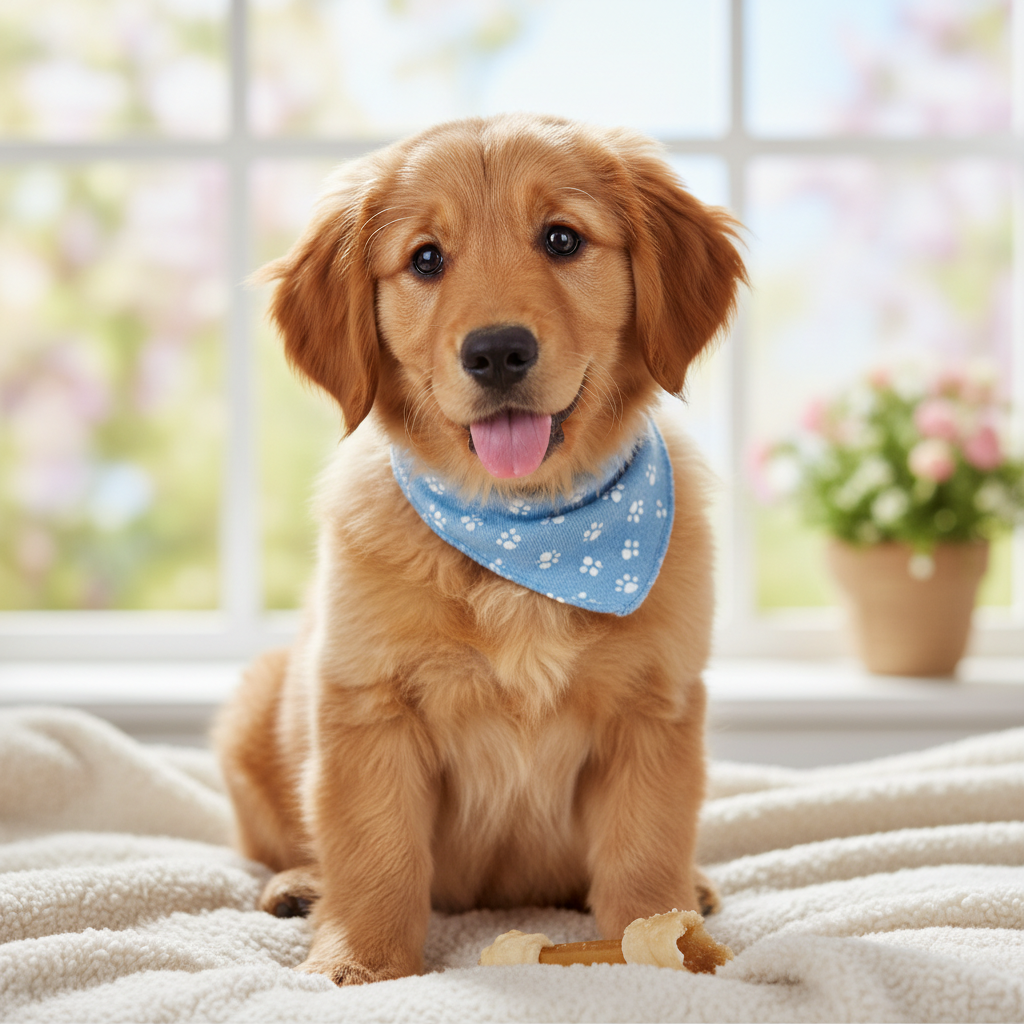

In [26]:
from PIL import Image
from IPython.display import display

for block in resp.message.blocks:
    if isinstance(block, ImageBlock):
        image = Image.open(block.resolve_image())
        display(image)
    elif isinstance(block, TextBlock):
        print(block.text)

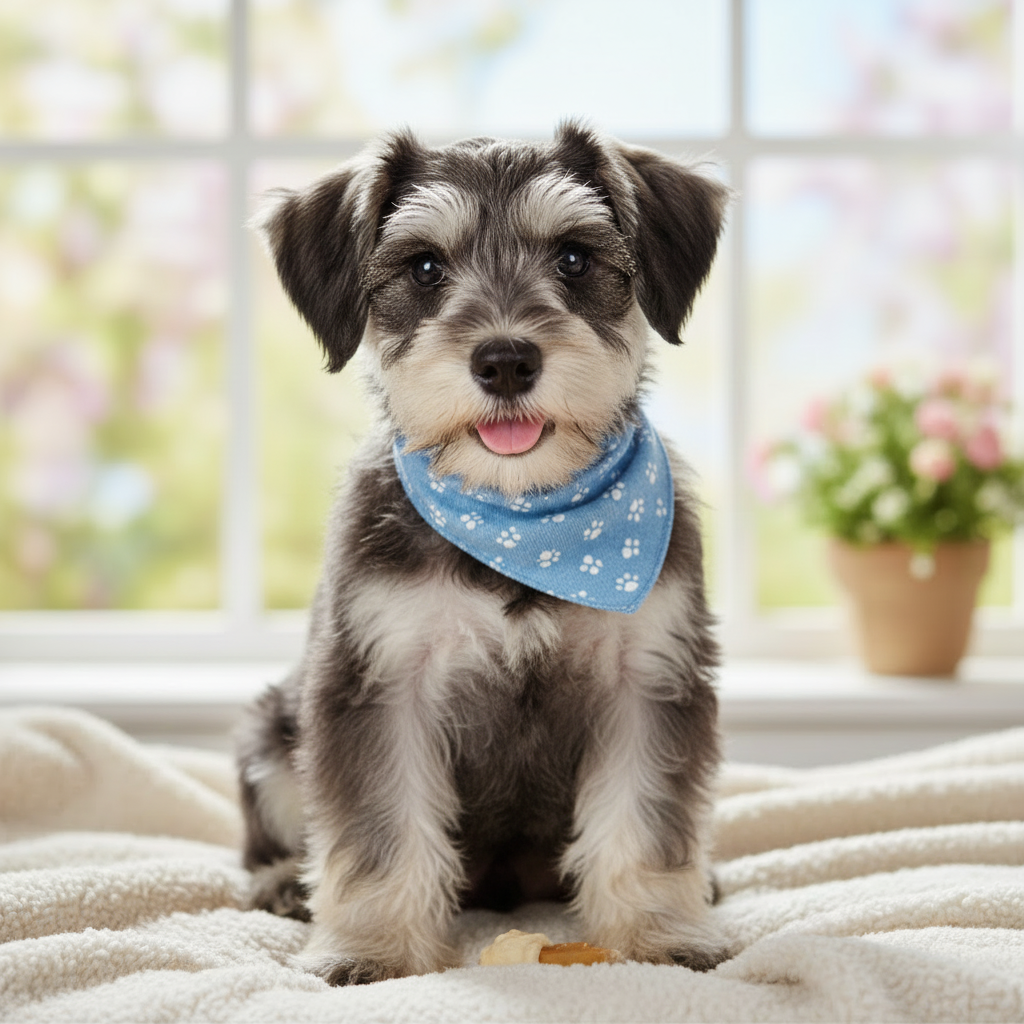

In [27]:
messages.append(resp.message)
messages.append(
    ChatMessage(
        role="user",
        content="Please edit the image to make the dog a mini-schnauzer, but keep the same overall pose, framing, background, and art style.",
    )
)

resp = await llm.achat(messages)

for block in resp.message.blocks:
    if isinstance(block, ImageBlock):
        image = Image.open(block.resolve_image())
        display(image)
    elif isinstance(block, TextBlock):
        print(block.text)

### Storing - Vector Store

In [ ]:
!pip install chromadb llama-index-vector-stores-chroma llama-index-embeddings-google-genai

1. Create index, and store it in Vector store

In [28]:
from google.genai.types import EmbedContentConfig
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader, StorageContext
from llama_index.embeddings.google_genai import GoogleGenAIEmbedding
from llama_index.vector_stores.chroma import ChromaVectorStore

import chromadb

embed_model = GoogleGenAIEmbedding(
    model_name="gemini-embedding-001",
    embed_batch_size=100,
    vertexai_config={
        "project": PROJECT_ID,
        "location": LOCATION,
    }
)

llm = GoogleGenAI(
    model="gemini-2.5-flash", 
    vertexai_config={"project": PROJECT_ID, "location": LOCATION},
    embed_model=embed_model
)

# load some documents
documents = SimpleDirectoryReader("./data").load_data()

# initialize client, setting path to save data
db = chromadb.PersistentClient(path="./chroma_db")

# create collection
chroma_collection = db.get_or_create_collection("learnai")

# assign chroma as the vector_store to the context
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
storage_context = StorageContext.from_defaults(vector_store=vector_store)

# create your index
index = VectorStoreIndex.from_documents(
    documents, 
    storage_context=storage_context,
    show_progress=True,
    embed_model=embed_model
)

# create a query engine and query
query_engine = index.as_query_engine(
    llm=llm
)
response = await query_engine.aquery("What is a discriminative AI?")
print(response)

2026-02-22 21:48:29,256 - INFO - Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
/home/baliga/development/AI/learn-AI/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating embeddings: 100%|██████████| 11/11 [00:12<00:00,  1.15s/it]
2026-02-22 21:48:53,586 - INFO - AFC is enabled with max remote calls: 10.


A discriminative AI is a type of artificial intelligence that functions like a detective, identifying things based on previously encountered evidence. It learns to differentiate between various categories. An example of this is an image classifier that can determine if a picture contains a cat or a dog.


2. Load from VectorStore

In [29]:
from google.genai.types import EmbedContentConfig
from llama_index.core import VectorStoreIndex, SimpleDirectoryReader, StorageContext
from llama_index.embeddings.google_genai import GoogleGenAIEmbedding
from llama_index.vector_stores.chroma import ChromaVectorStore

import chromadb

embed_model = GoogleGenAIEmbedding(
    model_name="gemini-embedding-001",
    embed_batch_size=100,
    vertexai_config={
        "project": PROJECT_ID,
        "location": LOCATION,
    }
)

llm = GoogleGenAI(
    model="gemini-2.5-flash", 
    vertexai_config={"project": PROJECT_ID, "location": LOCATION},
    embed_model=embed_model
)

# initialize client, setting path to save data
db = chromadb.PersistentClient(path="./chroma_db")

# create collection
chroma_collection = db.get_or_create_collection("learnai")

# assign chroma as the vector_store to the context
vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
storage_context = StorageContext.from_defaults(vector_store=vector_store)

# load your index from stored vectors
index = VectorStoreIndex.from_vector_store(
    vector_store, storage_context=storage_context, embed_model=embed_model, show_progress=True
)

# create a query engine
query_engine = index.as_query_engine(
    llm=llm
)

2026-02-22 21:49:13,349 - INFO - The user provided project/location will take precedence over the Vertex AI API key from the environment variable.
2026-02-22 21:49:13,390 - INFO - The user provided project/location will take precedence over the Vertex AI API key from the environment variable.
2026-02-22 21:49:15,246 - INFO - HTTP Request: GET https://aiplatform.googleapis.com/v1beta1/publishers/google/models/gemini-2.5-flash "HTTP/1.1 200 OK"


In [30]:
question = input("Enter a question to ask the index: ")
response = await query_engine.aquery(f"Answer the user's question. If you cannot find any relevant information, say you don't know.\n Question: {question}")
print(response)

2026-02-22 21:49:51,202 - INFO - AFC is enabled with max remote calls: 10.


Generative AI is a type of artificial intelligence focused on creating new, original content that resembles the data it was trained on. Unlike AI that only analyzes or classifies existing data, Generative AI can produce text, images, audio, videos, and code. It learns underlying patterns in data and uses that knowledge to generate novel content.
